# Demand Estimation Exercise

In this assignment, you will learn how to simulate market data and estimate simple random coefficient demand models. The assignment should serve as an introduction to the structural estimation in heterogenous products demand models.

Let's first define the model.

todo: Here you need to insert all the model definiton and reference to the slides


$$ u_{ijt} = \beta_{it}^{'} x_j + \alpha_{it}p_{jt} + \xi_{jt} + \varepsilon_{ijt}$$

Where: 

$$ \alpha_{it} =  \mu_{\alpha} + \sigma_{\alpha} \nu_{it}^{\alpha} $$ 
$$ \beta_{it} =  \mu_{\beta} + \sigma_{\beta} \nu_{it}^{\beta} $$ 

And $\nu_{it}^{\alpha}$ and $\nu_{it}^{\beta}$ are standard normally distributed. 

TO DO: Define all the other parameters and how they are constructed in the simulation for the students 


decision to make: 
                - should they work only in pandas or in numpy?

                  - should they simulate data themselves? or just import my module?

                  - should they write the GMM estimator themselves or just apply pyBLP more times until convergence? 
                   
                  - maybe it is enough for them to write the strucural function parameters? 

                 


### Step 1: Simulate Data



In [1]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt

The first step is to initialize the model class

To do this you need to import the "simulation" module that was especially constructed for this course. Make sure the assignment notebook and the simulate are in the same folder if you have not prespecified a different path for the module.  (FIND A WAY FOR THE STUDENTS TO NOT RUN IT LOCAL, BUT ON THE GIT SERVER SUCH THAT THEY DO NOT NEED TO HAVE ANYTHING INSTALLED)

Lets start by setting the parameters defining the market. These include the number of firms `n_firms`, number of consumers `n_cons`, number of product charactistics `n_char` and the number of time periods (or separated markets) `T`. The larger numbers you choose the longer the opimization will take. 

We have now created an _object_, which contains all the data and functions used to generate the data. The `market.py` file contains the Python code used to define this object. The simulation code makes use of the Object-Oriented Programming (OOP) paradigm. You do not need to change this code, but you can give it a look and try to understand the simulation process. 

We can now print the object, which will give us a summary of the main parameters of our simulation:

In this exercise we are going to try and estimate the parameters underlying the indirect mean utility of the consumers for buying a certain product (again reference to the slide and certain). You can easily retrive the true parameters by running the code below.
THESE ARE THE PARAMETERS WE ARE GOING TO TRY AND ESTIMATE

### PART 1. Data exploration


Exercise 1: Look into the data characterizing you market. Print the dataframe object. Describe what you see. Is it all realistic? Which values are you likely to not have as an econometrician working on real datasets?

In [2]:
df = pd.read_csv("simulation_data.csv")
print(df)

     market_ids  firm_ids    shares    prices      cost        xi     char1
0             1         1  0.000043  4.914348  3.262528 -0.042173  4.616823
1             1         2  0.000051  4.634007  3.331514 -0.135383  4.497339
2             1         3  0.000026  5.536855  3.358621  0.027024  4.888996
3             1         4  0.000038  4.896287  3.311746 -0.032851  4.744040
4             1         5  0.000022  6.333961  3.352858  0.219944  4.990127
..          ...       ...       ...       ...       ...       ...       ...
995         100         6  0.000048  4.293916  3.295705 -0.192426  4.682268
996         100         7  0.000030  6.300923  3.364446  0.177320  4.420019
997         100         8  0.000036  6.510156  3.351038  0.253008  4.217225
998         100         9  0.000017  7.528117  3.327199  0.394304  4.728908
999         100        10  0.000063  3.579614  3.364513 -0.438902  4.737151

[1000 rows x 7 columns]


Exercise 2: Create a histogram with: 

1. The distribution of prices 
2. The distribution of market shares 

You should use the columns from the generated dataframe. 

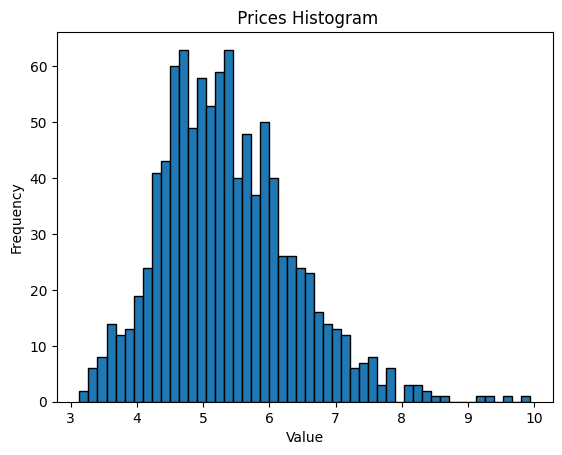

In [3]:
# Create a histogram
plt.hist(df["prices"], bins=50, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(' Prices Histogram')

# Display the plot
plt.show()

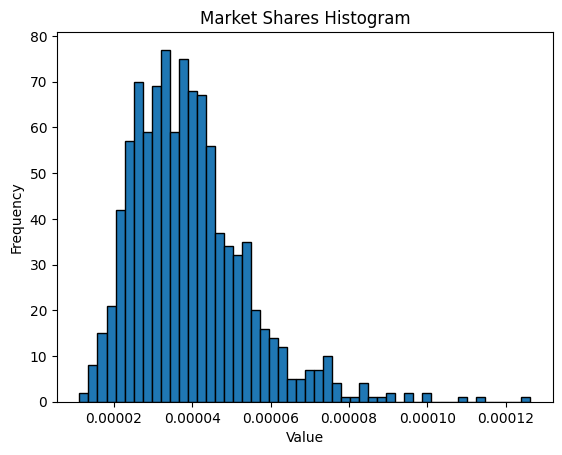

In [4]:
# Create a histogram
plt.hist(df["shares"], bins=50, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Market Shares Histogram')

# Display the plot
plt.show()

### Part 2: Simple Logit Estimation

Exercise 1: Estimate the simple logit model disregarding consumer heterogeneity

Trying to estimate with the logit function: 

$$ ln(s_j) - ln(s_0) =   \beta^{'} x_j + \alpha p_{jt}  $$

Check if this estimation leads to the correct coefficients and what we can do to improve it. 

In [5]:
df_group_marked_id = df.groupby('market_ids').sum()
outside_good_share = np.repeat((1 - np.array(df_group_marked_id['shares'])), 10)
y = np.log(df['shares']) - np.log(outside_good_share)


In [6]:
x = df[['prices','char1', 'xi']]
# with sklearn
mod = sm.OLS(y, x).fit()
print(mod.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          5.894e+05
Date:                Mon, 30 Oct 2023   Prob (F-statistic):                        0.00
Time:                        14:00:45   Log-Likelihood:                         -2.3955
No. Observations:                1000   AIC:                                      10.79
Df Residuals:                     997   BIC:                                      25.51
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Exercise 2: Compare the estimates with the true estimates? What is wrong here? 


/var/folders/v2/756s2x392yg86b682tz_zrl80000gn/T/ipykernel_11232/3160197288.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = mod.params[i]
/var/folders/v2/756s2x392yg86b682tz_zrl80000gn/T/ipykernel_11232/3160197288.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = mod.bse[i]


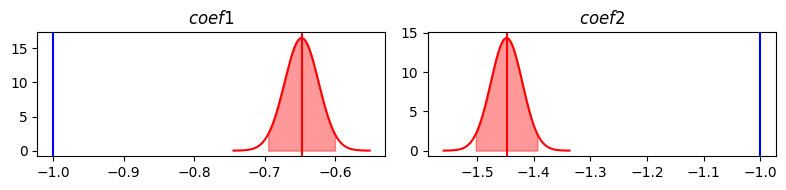

In [7]:
# Additional visualization students do not need to do this but it is good for 
# visualization

fig, axes = plt.subplots(1, 2, figsize=(8, 2))

for i,ax in enumerate(axes.flatten()):
    ax.axvline(np.vstack((-1., -1.))[i], label="true", color="blue")

    # Plot (distribution of) estimated coefficient
    mu = mod.params[i]
    sigma = mod.bse[i]
    x1 = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    x2 = np.linspace(mu - 1.96*sigma, mu + 1.96*sigma, 1000)
    
    ax.axvline(mu, label="estimated", color="red")
    ax.plot(x1, norm.pdf(x1, mu, sigma), color="red")
    ax.fill_between(x2, norm.pdf(x2, mu, sigma), color="red", alpha=0.4)
    
    ax.set_title(f"$coef{i+1}$")

plt.tight_layout()
plt.show()

### Part 3 - GMM algorithm for accounting for unobserved product characteristics 

Guided Monte Carlo Estimation 


All the funcitons are written for you, you only need to compare the estimates in
the end and calculate and compare elasticities 

In [8]:
# Global estimation variables 
n_firms = 10
n_cons = 10000
T = 100

In [9]:
def gen_price_random_coeff(alpha_sd, v_p, df): 
        """
        TODO
        """
        random_coefficient_prices = np.zeros((n_firms*n_cons*T, 1))
        alpha_i = np.zeros((n_cons*T, 1))
        for t in range(T):
            price_r = (np.array(df['prices'][t*n_firms : (t + 1)*n_firms])).reshape(1, n_firms)
            period_v_p = v_p[t*n_cons : (t + 1)*n_cons]
            alpha_i_per_period = np.reshape(alpha_sd*period_v_p, 
                                             (n_cons, 1))
            c_times_f = n_cons*n_firms
            alpha_i[t*n_cons: (t + 1)*n_cons] = alpha_i_per_period 
            reshaped =  np.reshape(np.ravel((alpha_i_per_period*price_r).T), (c_times_f, 1))
            random_coefficient_prices[t*c_times_f : (t + 1)*c_times_f] = reshaped
        return random_coefficient_prices

In [10]:
def gen_estimated_utilities(alpha_mean, beta, df): 
    """
    TODO
    """
    estimated_mean_utlities = np.zeros((n_firms*T, 1))
    for t in range(T):
        price_r = np.array(df['prices'][t*n_firms : (t + 1)*n_firms]).reshape(n_firms, 1)
        product_chars_period = np.array(df['char1'][t*n_firms : (t + 1)*n_firms]).reshape(n_firms, 1)
        xi_per = np.array(df['xi'][t*n_firms : (t + 1)*n_firms]).reshape(n_firms, 1)
        mean_indirect_utilities_period = beta*product_chars_period + alpha_mean*price_r + xi_per
        reshaped = np.reshape(mean_indirect_utilities_period, (n_firms, 1))
        estimated_mean_utlities[t*n_firms:(t + 1)*n_firms] = reshaped
    return estimated_mean_utlities


In [11]:
def gen_estimated_market_share(theta, v_p, df):

    # Unpack theta
    # print(theta)

    alpha_sd = theta[0]
    alpha_mean = theta[1]
    beta = theta[2]

    estimated_market_shares = np.zeros((n_firms*T, 1))
    random_coeff_price = gen_price_random_coeff(alpha_sd, v_p, df)
    mean_utilities = gen_estimated_utilities(alpha_mean, beta, df)
    
    for t in range(T):
        c_times_f = n_cons*n_firms
        coeff_per_T = random_coeff_price[t*c_times_f : (t + 1) * c_times_f]
        repeat_u = np.repeat(mean_utilities[t*n_firms : (t + 1)*n_firms]
                             , n_cons, axis=0)                
        u = repeat_u + coeff_per_T 
        u_r = np.reshape(u, (n_firms, n_cons))
        sum_u = np.sum(np.exp(u_r), axis=0)
        all_probs = np.exp(u_r)/(1 + sum_u)
        market_shares = np.sum(all_probs, axis=1)/n_cons
        reshaped = np.reshape(market_shares, (n_firms, 1))
        estimated_market_shares[t*n_firms:(t + 1)*n_firms] = reshaped

    return estimated_market_shares

In [12]:
def f(theta, v_p, df):
    true_shares = np.array(df['shares'])
    estimated_market_shares = gen_estimated_market_share(theta, v_p, df)
    # val = np.linalg.norm(np.log(true_shares) -  np.log(estimated_market_shares))
    A = np.log(true_shares)
    B = np.log(estimated_market_shares)
    val = np.square(np.subtract(A, B)).mean()
    return val

In [13]:
theta_0= [0.5, -0.6477, -1.4479]


N_simulation = 5

results = np.zeros((N_simulation, 3))
print(results)

for n in range(N_simulation):
    v_p_monte = np.random.normal(0, 1, (n_cons*T, 1))
    res = optimize.minimize(f, theta_0, args=(v_p_monte, df), bounds=((0., 1.), (-3., -1.), (-2., -0.5)))
    results[n,:] = res.x



print(results)


[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [ ]:
print(results.mean(axis=0))
print


[ 0.53290352 -1.68113824 -1.11865267]


### Calculate price elasticities with simple logit and the random coefficients estimates and discuss your results (max 150w)




### Part 4. Bonus Question (not mandatory)

Estimate the model in the more realistic case where you do not know the product-specific fixed efffects $\xi$. For this you can use the costs in the dataframe as instruments. Recall that the GMM estimation can be calculated as: 

In the _outer loop_, the GMM estimation procedure relies on the properties of the price instruments in order to retrieve the unbiased price coefficients. For this estimation, I will use supply side instruments. Thus, the GMM estimator can be defined as: 

$$ \min_{(\mu_p, \sigma_p, \mathbf{\beta})} q(\mu_p, \sigma_p, \boldsymbol{\beta}) = g_s(\mu_p, \sigma_p, \boldsymbol{\beta})'W g_s(\mu_p, \sigma_p, \boldsymbol{\beta}) $$

Where $g_s(\mu, \sigma, \boldsymbol{\beta})$ is given as:


$$ g_s(\mu_p, \sigma_p, \boldsymbol{\beta}) = \left[ \frac{1}{N}\sum_{j,t} \kappa_{jt}Z^s_{jt} \right]$$
    
Here, $Z^s_{jt}$ represents cost levels and $\kappa_{jt}$ represents the error in the functional form of the marginal cost imposed by the model 


Make use of the functions build for you in the guided Monte Carlo Estimation. 



In [ ]:
###